<a href="https://colab.research.google.com/github/rcpsousa/Ioslides_css/blob/master/GPU_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GPU programming. A starter.
This exercise introduces GPU programming using cuda-c. We will start by installing pycuda. After that, we define some magic, which helps you work with your kernel more easily. Then, a short and easy example will be given. Next, we'll show you an example using Pytorch.

Let's examine pycuda, a program that is not installed in Colab in the first example. Installing it is the first step.

In [ ]:
!pip install pycuda
import pycuda.driver as cuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=bbd6fc2afc7297c028b09b95ae0c9e74956b0b00239fd72714a70b5706a63d1a
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda


# Some wizardry
A little magic was thrown in to make it easier to work with the examples. Don't worry, you don't have to understand it, but you can look at it if you want. To me, this kind of magic is fun. After all, coding can be fun and creative.

In [ ]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from IPython.core.display import display_javascript

from pycuda.compiler import SourceModule
import pycuda.autoinit
import re
import numpy as np




@register_cell_magic
def CudaKernel(line, cell):
  # p : regular expression for extracting the name of the kernel from the cuda code
  p = re.compile('__global__\s+(void|int|float|double|char)\s+([a-zA-Z_]+([0-9_]*[a-zA-Z_]*)*)')
  # cell keeps the cuda-c source code (the content of the cell). With SourceModule we load it
  mod = SourceModule(cell)
  # now we use the regular expression p for finding the kernel names.
  M = p.findall(cell)
  # Each kernel is added to the global namespace with its own name.
  # With mod.get_function, we retreive the function.
  for m in M:
    globals()[m[1]] = mod.get_function(m[1])
    print(f"function {m[1]} created.")

js = "IPython.CodeCell.options_default.highlight_modes['magic_text/x-csrc'] = {'reg':[/^%%CudaKernel/]};"
display_javascript(js, raw=True)

#CUDA

With this CudaKernel Magic, we can create a simple program, which doubles the content of a 32 by 32 array:

In [ ]:
%%CudaKernel
__global__ void doublify(float *a) {
  int idx = threadIdx.x + threadIdx.y*32;
  a[idx] *= 2;
}


You can think of Cuda-C as a dialect of C. Multidimensional arrays are one-dimensional, and a pointer to that array is passed to the function. Furthermore, there are some important things to note. We see that, despite the program running on a matrix, it is only working with one element of the array: a[idx]. To run this code, 32 x 32 = 1024 cores are allocated. ThreadIdx.x, threadIdx.y tells us which thread we're using and, therefore, which node to process. These aren't the only variables we have. Each thread is identified by a blockId (with its x, y, and z components) and a threadId (with its x, y, and z components). The variable blockSize (with its x, y, and z components) tells a thread how many threads are in a block.

We'll see this later in the example. Let's run this program for now. We'll need to create a 32 by 32 matrix and copy it to the GPU:

In [ ]:
# create a random 32 x 32 matrix of type float32
a = np.random.randn(32,32).astype(np.float32)

# allocate memory on the GPU
a_gpu = cuda.mem_alloc(a.nbytes)
# copy the array to the gpu using the "memcpy host to device" (mem_htod) function
cuda.memcpy_htod(a_gpu,a) # note that the first parameter is the destination and the second the origin.

Now that all the data is on the GPU, we can run the kernel. The block has to be 32 by 32 threads. You do that with the block-parameter (32 x 32 x 1). A pointer to the array is passed and computation can start. The kernel will process the data and the results will be stored in the same array.

In [ ]:
doublify(a_gpu, block=(32,32,1))

Afterwards, you can copy the data back to the CPU. We need an array to hold the results and copy the data from the GPU to the CPU using memcpy_dtoh (device to host). In our case, the array should have the same size as the original array. Finally, we need to free the memory allocated to the GPU. Then, we can use the results from the CPU array.

In [ ]:
# create an array with the same size as the input array
a_doubled = np.empty_like(a)
# copy the data from device to host
cuda.memcpy_dtoh(a_doubled, a_gpu) # note that the first parameter is the destination and the second the origin.
# Free the memory of the GPU
a_gpu.free()

print(a_doubled)

**That's it. Our first CUDA program!!!**

The number of cores on this card is defined as follows. First we look at the amount of multiprocessors. Each multiprocessor consists of a certain number of cores, determined by its version. For instance, a compute capability of 7.5 means 64 cores per multiprocessor. So that would mean that our GPU has 40 times 64 is 2560 cores.

In [ ]:

def ConvertSMVer2Cores(major, minor):
    # Returns the number of CUDA cores per multiprocessor for a given
    # Compute Capability version. There is no way to retrieve that via
    # the API, so it needs to be hard-coded.
    # See _ConvertSMVer2Cores in helper_cuda.h in NVIDIA's CUDA Samples.
    return {(1, 0): 8,    # Tesla
            (1, 1): 8,
            (1, 2): 8,
            (1, 3): 8,
            (2, 0): 32,   # Fermi
            (2, 1): 48,
            (3, 0): 192,  # Kepler
            (3, 2): 192,
            (3, 5): 192,
            (3, 7): 192,
            (5, 0): 128,  # Maxwell
            (5, 2): 128,
            (5, 3): 128,
            (6, 0): 64,   # Pascal
            (6, 1): 128,
            (6, 2): 128,
            (7, 0): 64,   # Volta
            (7, 2): 64,
            (7, 5): 64,   # Turing
            (8, 0): 64,   # Ampere
            (8, 6): 64,
            }.get((major, minor), 0)

device=cuda.Device(0)
attrs=device.get_attributes()
#print(f"warp size: {attrs[pycuda._driver.device_attribute.WARP_SIZE]}")
print(f"multiprocessor count: {attrs[pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT]}")
major = attrs[pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MAJOR]
minor = attrs[pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MINOR]
print(f"compute capability: {major}.{minor}")
corespermultiprocessor = ConvertSMVer2Cores(major, minor)
print(f"Number of cores per multiprocessor: {corespermultiprocessor}")
print(f"Total number of cores: {corespermultiprocessor * attrs[pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT] }")

In [ ]:
%%CudaKernel
__global__ void doublify(float *a) {
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  a[idx] *= 2;
}


In [ ]:
# create a random 32 x 32 matrix of type float32
a = np.random.randn(1024,1024).astype(np.float32)

# allocate memory on the GPU
a_gpu = cuda.mem_alloc(a.nbytes)
# copy the array to the gpu using the "memcpy host to device" (mem_htod) function
cuda.memcpy_htod(a_gpu,a) # note that the first parameter is the destination and the second the origin.

doublify(a_gpu, block=(1024,1,1), grid=(1024,1,1))

# create an array with the same size as the input array
a_doubled = np.empty_like(a)
# copy the data from device to host
cuda.memcpy_dtoh(a_doubled, a_gpu) # note that the first parameter is the destination and the second the origin.
# Free the memory of the GPU
a_gpu.free()
print(a, a.shape)
print(a_doubled, a_doubled.shape)


# Exercise 1
Create a function triplify to triple the value of __a__. Hint: You can just copy and paste the code from above to get it up and running.

In [ ]:
# insert your code her

## find the maximum of an array
Some problems are hard to parallelize. One of these problems is the maximum of an array.

To do this, we can use a divide and conquer approach:
1. let a be the array with N elements
2. let n <= N
3. Reduce the array of n elements to n/2 elements by taking the maximum of  the i-th element and the (i+n/2)th element
4. n <= n/2
5. if n = 1/2 => stop
6. goto 2

In cuda-c this looks like this:




In [ ]:
%%CudaKernel
__global__ void max_iter(float *a, int *N)
{

    for (int n=((*N)>>1); n>0; n>>=1)
    {
        int idx = blockIdx.x * blockDim.x + threadIdx.x;
        if (idx < n)
        {
          int b = (a[idx] < a[idx + n]);
          a[idx] = a[idx + n*b];
        }
    }

}

Now let us test it.

In [ ]:
#define the array and upload it to the gpu
a = np.random.randn(2048).astype("float32")
a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)
#define a variable holding the length of the array and copy it to the gpu
N = np.array([a.shape[0]], dtype="int")
N_gpu = cuda.mem_alloc(N.nbytes)
cuda.memcpy_htod(N_gpu, N)
#call the max_iter kernel with half of the number of cores
max_iter(a_gpu, N_gpu, block=(a.shape[0]//2,1,1))
#define the return matrix and use it. We only need the first element,
#so we define an ndarray with one element.
a_max = np.zeros((1,), dtype = "float32")
cuda.memcpy_dtoh(a_max, a_gpu)
print(f"{a_max[0]} == {np.max(a)}")



# Exercise 2
Create a kernel to find:
- the minimum of an array, or
- the average of an array

In [ ]:
%%CudaKernel
// insert your cuda-c code here

In [ ]:
## insert your test code here

# pyTorch
For the remainder we will look at pyTorch. Torch is known to be used for training neural networks, but can also be used for other problems. Here, we will implement the 'doublify' example in pytorch. First we need to import torch:

In [ ]:
import torch
import numpy as np

First, we check if the GPU is available and we store its reference to device. We actually know that already, since we used it for the CUDA example.

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
dev

Now the fun can begin. We first create a torch tensor:

In [ ]:
a = np.random.randn(1000, 1000)
a_torch = torch.tensor(a)

# Exercise 3
To execute the tensor on a GPU, we have to create it on the GPU. This is done by specifying the device with the line `device=<device>`. Please change the code in the next block to use the device `dev`

In [ ]:
a = np.random.randn(1000, 1000, ###insert code here###)
a_torch = torch.tensor(a)

And like in the first example we double it. Note how easy this functions in pytorch.

In [ ]:
2*a_torch

In another example we will try to estimate the number pi with a monte carlo simulation. Therefore, we plot $N$ points on a square of 2 by 2. Then we draw a unity circle in the square and count the number of dots that fall within the circle. 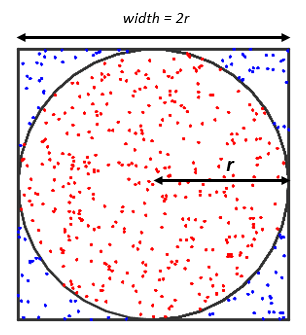

The probability that a point is inside the cirle is equal to $\frac \pi 4$, so we can estimate $\pi$ by calculating the fraction of points which are inside the circle and multiply it with 4.

The version in numpy:

In [ ]:
from time import time
N = 100000000;
tic = time();
x = np.random.rand(N,2)*2-1
y = ((x[:,0]**2+x[:,1]**2)<=1)
n = y.sum()
toc = time()
print(f"Pi is approximately {4* n/N} (in {round(1000*(toc-tic))} ms.)" )

# Exercise 4
The following cell shows the code for torch, but there is one mistake in the code, which makes that it does not work faster. Find the mistake and correct it.

In [ ]:
tic = time()
x = torch.rand(N,2)*2-1
y = ((x[:,0]**2+x[:,1]**2)<=1)
n = y.sum()
toc = time()
print(f"Pi is approximately {4* n/N} (in {round(1000*(toc-tic))} ms.)" )